In [1]:
import PyPDF2
import spacy
import gensim
import wordcloud
import mlflow
import requests
import pyspark
import string
import json
import io
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [2]:
esg_urls_rows = [
  ['Koufu', 'http://investor.koufu.com.sg/newsroom/20200529_184628_VL6_7DORXO3LL3T5LQSB.1.pdf'],
  ['Jumbo Group', 'http://investor.jumbogroup.sg/newsroom/20200228_171455_42R_6G7HX0EHXK5F9JD5.1.pdf'],
  ["McDonald's", 'https://www.mcdonalds.co.jp/common/company/csr/assets/pdf/CSR2018_e.pdf'],
  ['Thai Village Restaurant', 'https://thaivillagerestaurant.com.sg/wp-content/uploads/2020/05/Sustainability-Report-2019.pdf'],
  ['Cheesecake Factory', 'https://www.thecheesecakefactory.com/assets/pdf/2019-CSR-Report-The-Cheesecake-Factory.pdf'],
  ['Autogrill', 'https://www.autogrill.com/sites/autogrill14corp/files/dnf_2019_en.pdf'],
  ['Spur Steak Ranches', 'https://www.spurcorporation.com/wp-content/uploads/2020/11/Online-Sustainability-Report-FINAL.pdf'],
  ["Domino's Pizza", 'https://www.annualreports.com/HostedData/AnnualReportArchive/d/ASX_DMP_2015.pdf'],
]

In [3]:
esg_urls_pd = pd.DataFrame(esg_urls_rows, columns=['company', 'url'])

In [4]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    try:
      # retrieve PDF binary stream
        response = requests.get(url)
        open_pdf_file = io.BytesIO(response.content)
        pdf = PyPDF2.PdfFileReader(open_pdf_file)  
        # access pdf content
        text = [pdf.getPage(i).extractText() for i in range(0, pdf.getNumPages())]
        # return concatenated content
        return "\n".join(text)
    except:
        return ""

In [5]:
# add the pdf content into the dataframe
esg_urls_pd['content'] = esg_urls_pd.apply(lambda row: extract_content(row['url']), axis=1)

In [6]:
# add the 
esg_urls_pd = esg_urls_pd.loc[(esg_urls_pd['content'].str.len() > 0)]

In [7]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

In [8]:
def extract_statements(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
  
    # remove non ASCII characters
    text = remove_non_ascii(text)
  
    lines = []
    prev = ""
    for line in text.split('\n'):
        # aggregate consecutive lines where text may be broken down
        # only if next line starts with a space or previous does not end with dot.
        if(line.startswith(' ') or not prev.endswith('.')):
            prev = prev + ' ' + line
        else:
            # new paragraph
            lines.append(prev)
            prev = line
        
    # don't forget left-over paragraph
    lines.append(prev)

    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    sentences = []
    for line in lines:
    
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub('\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub('\s+', ' ', line)
      
        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

    return sentences

In [9]:
def extract_statements_udf(content_series_iter):
    """
    as loading a spacy model takes time, we certainly do not want to load model for each record to process
    we load model only once and apply it to each batch of content this executor is responsible for
    """
  
    # load spacy model
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
    # cleanse and tokenize a batch of PDF content 
    return extract_statements(nlp, content_series_iter)
#     for content_series in content_series_iter:
#         return content_series.map(lambda x: extract_statements(nlp, x))

In [10]:
esg_urls_pd['statement'] = esg_urls_pd.apply(lambda row: extract_statements_udf(row['content']), axis=1)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
esg_urls_pd = esg_urls_pd.explode('statement').reset_index(drop=True)

In [12]:
esg_urls_pd = esg_urls_pd.loc[(esg_urls_pd['statement'].str.len() > 100)]

In [13]:
esg_urls_pd2 = esg_urls_pd.loc[:,['company', 'statement']]

In [14]:
def tokenize(sentence):
    gen = gensim.utils.simple_preprocess(sentence, deacc=True)
    return ' '.join(gen)

def lemmatize(nlp, text):
  
    # parse sentence using spacy
    doc = nlp(text) 
  
    # convert words into their simplest form (singular, present form, etc.)
    lemma = []
    for token in doc:
        if (token.lemma_ not in ['-PRON-']):
            lemma.append(token.lemma_)
          
    return tokenize(' '.join(lemma))

In [15]:
def lemma(content_series_iter, nlp):
    """
    as loading a spacy model takes time, we certainly do not want to load model for each record to process
    we load model only once and apply it to each batch of content this executor is responsible for
    """

    # load spacy model
#     spacy.cli.download("en_core_web_sm")
#     nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
    # lemmatize a batch of text content into sentences
    return lemmatize(nlp, content_series_iter)
#     for content_series in content_series_iter:
#         yield content_series.map(lambda x: lemmatize(nlp, x))

In [16]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
esg_urls_pd2['lemma'] = esg_urls_pd2.apply(lambda row: lemma(row['statement'], nlp), axis=1)

In [18]:
esg_urls_pd2

,company,statement,lemma
0,Koufu,SUSTAINABILITY REPORT 2020BETTER BETTER BETTER Zero major food incidents at Koufus outlets Zero incidents of non-compliance with voluntary codes and regulations resulting in a warning Average score of >70% for Mystery Shopper programmeSUSTAINABILITY HIGHLIGHTS IN FY2019 BETTER food SUSTAINABILITY HIGHLIGHTS IN FY2019 food peopleBETTER Maintained monthly turnover rate <4% Zero high-consequence work-related injury Zero fatality SUSTAINABILITY HIGHLIGHTS IN FY2019,sustainability report better better better zero major food incident at koufus outlet zero incident of non compliance with voluntary code and regulation result in warning average score of for mystery shopper highlights in fy well food sustainability highlight in fy food peoplebetter maintain monthly turnover rate zero high consequence work relate injury zero fatality sustainability highlight in fy
1,Koufu,"peoplelifeBETTER Zero conrmed cases of corruptionZero cases involving signicant nes and non-monetary sanctions Over S$500,000 community investment in cash and in-kind donations Over 5,500 employee volunteering hours clocked CONTENTS 1About Koufu Group Limited2Our Presence3Our Misssion & Values 4Statement from the Board5About the Report Reporting Period and Scope Reporting Standards Commitment to Quality Disclosures",zero conrme case of corruptionzero case involve signicant ne and non monetary sanction over community investment in cash and in kind donation over employee volunteer hour clock content about koufu group limited our presence our misssion value statement from the board about the report report period and scope reporting standards commitment to quality disclosures
2,Koufu,6Koufus Sustainability Approach Stakeholder Engagement Materiality Assessment Koufus Sustainable Value Chain Koufus Sustainability Governance12Better Food Food Safety and Hygiene Customer Satisfaction 17Better People,koufus sustainability approach stakeholder engagement materiality assessment koufus sustainable value chain koufus sustainability governance better food food safety and hygiene customer satisfaction better people
3,Koufu,"Our Workforce Prole Active Employee Engagement Occupational Health and Safety 27Better Life Corporate Governance Economic Performance33Global Reporting Initiative (GRI) Content Index 1Founded in 2002 by Mr. Pang Lim and headquartered in Singapore, Koufu Group Limited (Koufu) has been one of Singapores most well-known operators and managers of food courts and coee shops.",our workforce prole active employee engagement occupational health and safety better life corporate governance economic performance global reporting initiative gri content index founde in by mr pang lim and headquarter in singapore koufu group limited koufu have be one of singapore most well know operator and manager of food court and coee shop
6,Koufu,"Under the Outlet & Mall Management business segment, Koufu operates and/or manages food courts, coee shops, a hawker centre and a commercial mall.",under the outlet mall management business segment koufu operate and or manage food court coee shop hawker centre and commercial mall
...,...,...,...
5153,Domino's Pizza,"Don then became a Dominos Pizza franchisee, owning and operating 17 stores before selling them to Dominos Pizza in 2001.",don then become dominos pizza franchisee own and operate store before sell they to dominos pizza in
5154,Domino's Pizza,"At that time, Don became Chief Operating Ofcer and Chief Executive Ofcer / Managing Director in 2002.",at that time don become chief operating ofcer and chief executive ofcer managing director in
5157,Domino's Pizza,"COMPANY SECRETARY Mr C.A. Ryan BA LLB LLM AGIS REGISTERED OFFICEDominos Pizza Enterprises Ltd ABN 16 010 489 326 KSD1, L5 485 Kingsford Smith Drive Hamilton Brisbane QLD",company secretary mr ryan ba llb llm agis registered officedominos pizza enterprises ltd abn ksd kingsford smith drive hamilton brisbane qld
5163,Domino's Pizza,"Geer Lawyers Level 16

In [19]:
esg = esg_urls_pd2.copy()

In [20]:
fsi_stop_words = [
    'plc', 'group', 'target',
    'track', 'capital', 'holding',
    'report', 'annualreport',
    'esg', 'bank', 'report',
    'annualreport', 'long', 'make',
    'company', 'year'
]

In [21]:
for fsi in [row[0] for row in esg_urls_rows]:
    for t in fsi.split(' '):
        fsi_stop_words.append(t.lower())

In [22]:
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)

In [23]:
large_string = ' '.join(esg.lemma)

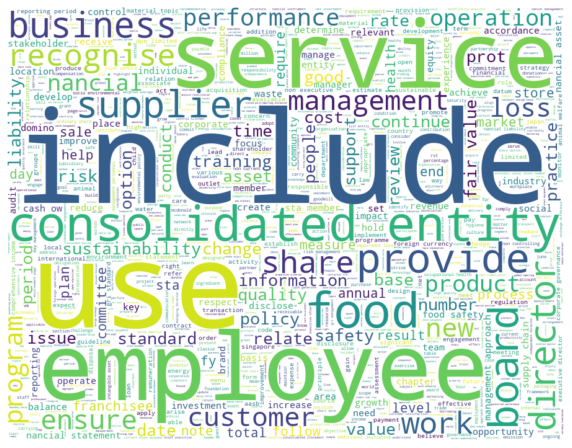

In [24]:
# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

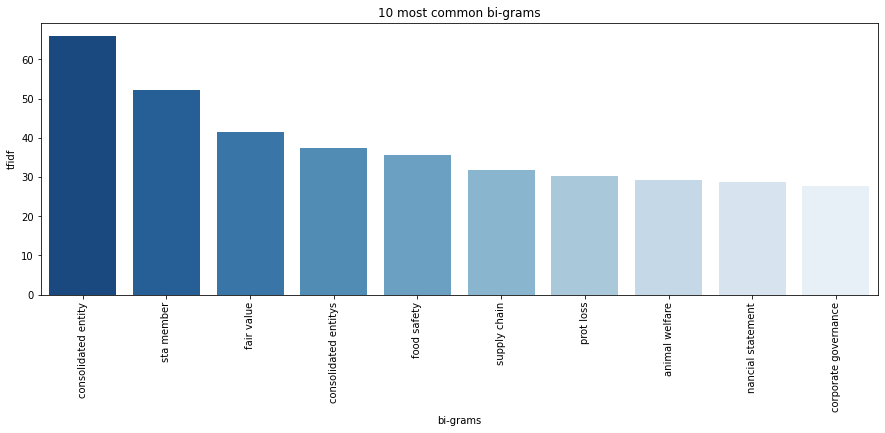

In [25]:
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(esg.lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(15, 5))
plt.subplot(title='10 most common bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('bi-grams')
plt.ylabel('tfidf')
plt.show()

In [26]:
# Compare to NMF, LDA would not require inverse document frequency as it will learn probability distribution of term frequencies
word_tf_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(esg.lemma)

# serialize stopwords
json_data = json.dumps([a for a in stop_words], indent=2)
f = open("/tmp/stopwords.json", "w")
f.write(json_data)
f.close()
  
# track experiment on MLflow
with mlflow.start_run(run_name='topic_modelling'):
  
    # Train a LDA model with 9 topics
    lda = LDA(random_state = 42, n_components = 9, learning_decay = .3)
    lda.fit(word_tf)
  
    # Log model 
    mlflow.sklearn.log_model(lda, "model")
    mlflow.log_param('n_components', '9')
    mlflow.log_param('learning_decay', '.3')
    mlflow.log_metric('perplexity', lda.perplexity(word_tf))
    mlflow.log_artifact("/tmp/stopwords.json")
  
    # retrieve run ID to attach topic name later
    lda_run_id = mlflow.active_run().info.run_id

In [27]:
def top_words(model, feature_names, n_top_words):
    rows = []
    for topic_idx, topic in enumerate(model.components_):
        message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        rows.append(["Topic #%d: " % (topic_idx + 1), message])
    return pd.DataFrame(rows, columns=['topic', 'keywords'])

# Display topics keywords for inspection and for us to label topics
tf_feature_names = word_tf_vectorizer.get_feature_names()
display(top_words(lda, tf_feature_names, 15))

,topic,keywords
0,Topic #1:,"safety, sustainability, employee, food, business, customer, training, management, new, ensure, health, standard, fy, quality, supplier"
1,Topic #2:,"director, board, executive, committee, management, remuneration, audit, non, corporate, senior, limited, policy, directors, information, dpe"
2,Topic #3:,"gri, management, approach, environmental, topic, material, social, people, materiality, reporting, policy, guideline, datum, chain, governance"
3,Topic #4:,"food, quality, service, product, customer, waste, new, experience, work, continue, menu, need, sta, use, improve"
4,Topic #5:,"nancial, asset, consolidated, liability, entity, tax, recognise, statement, value, period, current, fair, non, aasb, cost"
5,Topic #6:,"share, page, issue, option, energy, provide, total, number, employee, food, august, consumption, service, management, community"
6,Topic #7:,"animal, supplier, sta, work, supply, welfare, member, program, management, good, practice, chain, include, require, use"
7,Topic #8:,"rate, cash, value, risk, lease, market, performance, use, base, fair, increase, segment, period, cost, estimate"
8,Topic #9:,"loss, prot, store, operation, hedge, employee, gain, foreign, recognise, income, investment, comprehensive, month, woman, consolidated"


In [32]:
# We estimated our topics to be described around the following themes
topic_names = [
  'product safety',
  'governance', 
  'sustainability reporting',
  'food quality',
  'accounting',
  'investment',
  'animal',
  'financial',
  'financial performance'
]

# serialize topic names
json_data = json.dumps(topic_names, indent=2)
f = open("/tmp/topics.json", "w")
f.write(json_data)
f.close()

# attach topics name to LDA model on mlflow
# we do not wish to re-open run_id and therefore alter start / end time
# instead, we log artifact to existing run
client = mlflow.tracking.MlflowClient()
client.log_artifact(lda_run_id, "/tmp/topics.json")

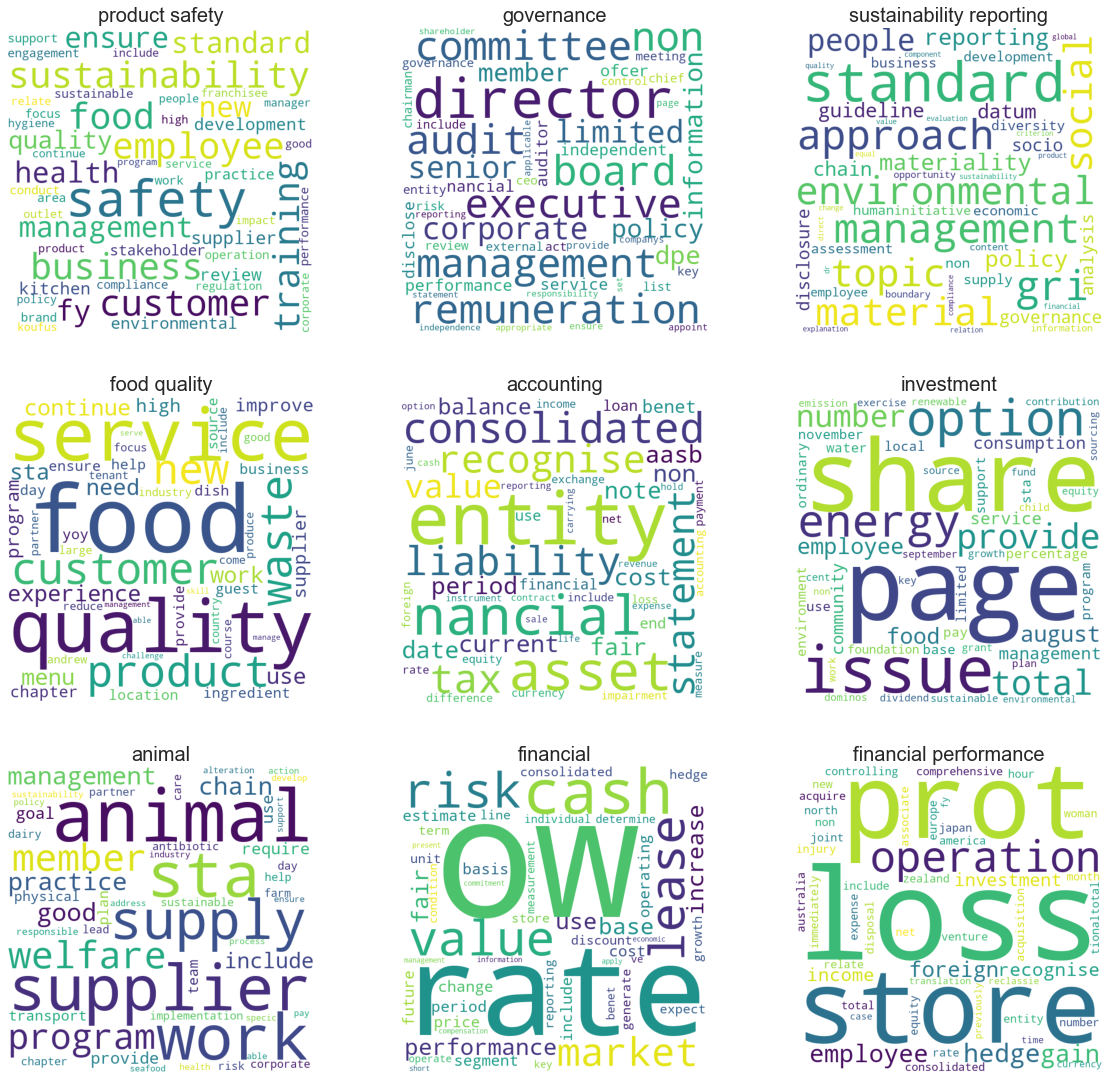

In [33]:
# We ensure relevance of our topics using simple wordcloud visualisation
def word_cloud(model, tf_feature_names, index):
    
    imp_words_topic=""
    comp = model.components_[index]
    vocab_comp = zip(tf_feature_names, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    
    return WordCloud(
        background_color="white",
        width=600, 
        height=600, 
        contour_width=3, 
        contour_color='steelblue'
    ).generate(imp_words_topic)
    
topics = len(lda.components_)
fig = plt.figure(figsize=(20, 20 * topics / 3))

# Display wordcloud for each extracted topic
for i, topic in enumerate(lda.components_):
    ax = fig.add_subplot(topics, 3, i + 1)
    ax.set_title(topic_names[i], fontsize=20)
    wordcloud = word_cloud(lda, tf_feature_names, i)
    ax.imshow(wordcloud)
    ax.axis('off')

In [34]:
# score our original dataset to attach topic distribution to each ESG statement
transformed = lda.transform(word_tf)

# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]

# ... with associated probability
b = [np.max(distribution) for distribution in transformed]

# consolidate LDA output into a handy dataframe 
df1 = esg[['company', 'lemma', 'statement']]
df2 = pd.DataFrame(zip(a,b,transformed), columns=['topic', 'probability', 'probabilities'])
esg_group = pd.concat([df1, df2], axis=1)

# display dataframe
display(esg_group[['company', 'lemma', 'topic', 'probability']])

,company,lemma,topic,probability
0,Koufu,sustainability report better better better zero major food incident at koufus outlet zero incident of non compliance with voluntary code and regulation result in warning average score of for mystery shopper highlights in fy well food sustainability highlight in fy food peoplebetter maintain monthly turnover rate zero high consequence work relate injury zero fatality sustainability highlight in fy,product safety,0.981083
1,Koufu,zero conrme case of corruptionzero case involve signicant ne and non monetary sanction over community investment in cash and in kind donation over employee volunteer hour clock content about koufu group limited our presence our misssion value statement from the board about the report report period and scope reporting standards commitment to quality disclosures,governance,0.306714
2,Koufu,koufus sustainability approach stakeholder engagement materiality assessment koufus sustainable value chain koufus sustainability governance better food food safety and hygiene customer satisfaction better people,product safety,0.734780
3,Koufu,our workforce prole active employee engagement occupational health and safety better life corporate governance economic performance global reporting initiative gri content index founde in by mr pang lim and headquarter in singapore koufu group limited koufu have be one of singapore most well know operator and manager of food court and coee shop,sustainability reporting,0.550863
4,NaN,NaN,food quality,0.461505
...,...,...,...,...
5153,Domino's Pizza,don then become dominos pizza franchisee own and operate store before sell they to dominos pizza in,NaN,NaN
5154,Domino's Pizza,at that time don become chief operating ofcer and chief executive ofcer managing director in,NaN,NaN
5157,Domino's Pizza,company secretary mr ryan ba llb llm agis registered officedominos pizza enterprises ltd abn ksd kingsford smith drive hamilton brisbane qld,NaN,NaN
5163,Domino's Pizza,geer lawyers level waterfront place eagle street brisbane qld dla piper australia level waterfront place eagle street brisbane qld share registry link market services limited level queen street brisbane qld,NaN,NaN


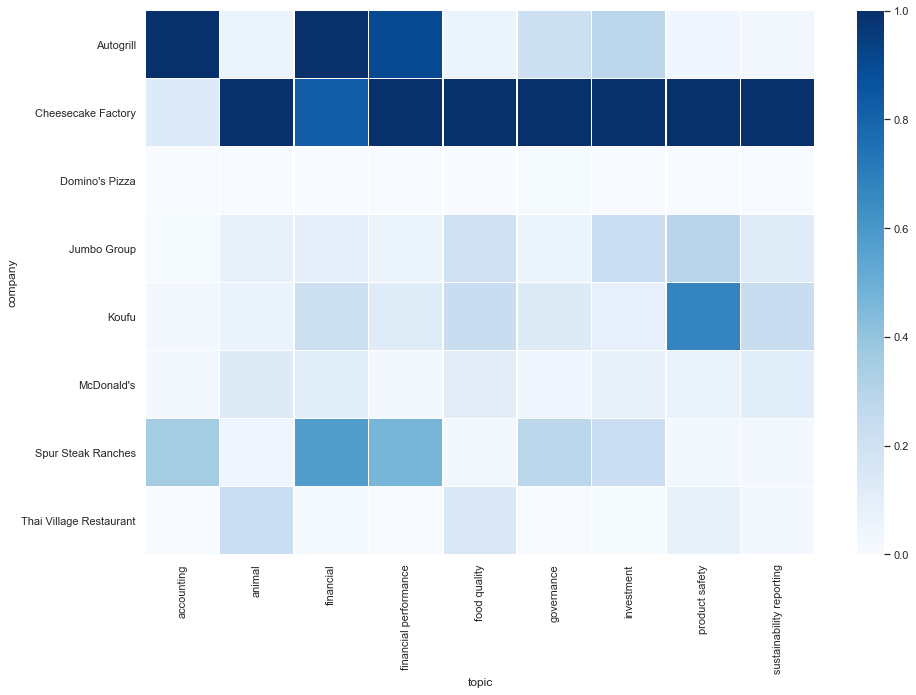

In [35]:
# create a simple pivot table of number of occurence of each topic across organisations
esg_focus = pd.crosstab(esg_group.company, esg_group.topic)

# scale topic frequency between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))

# normalize pivot table
esg_focus_norm = pd.DataFrame(scaler.fit_transform(esg_focus), columns=esg_focus.columns)
esg_focus_norm.index = esg_focus.index

# plot heatmap, showing main area of focus for each FSI across topics we learned
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(esg_focus_norm, annot=False, linewidths=.5, cmap='Blues')
plt.show()

In [36]:
esg_group[['company', 'lemma', 'topic', 'probability']].head(10)

,company,lemma,topic,probability
0,Koufu,sustainability report better better better zero major food incident at koufus outlet zero incident of non compliance with voluntary code and regulation result in warning average score of for mystery shopper highlights in fy well food sustainability highlight in fy food peoplebetter maintain monthly turnover rate zero high consequence work relate injury zero fatality sustainability highlight in fy,product safety,0.981083
1,Koufu,zero conrme case of corruptionzero case involve signicant ne and non monetary sanction over community investment in cash and in kind donation over employee volunteer hour clock content about koufu group limited our presence our misssion value statement from the board about the report report period and scope reporting standards commitment to quality disclosures,governance,0.306714
2,Koufu,koufus sustainability approach stakeholder engagement materiality assessment koufus sustainable value chain koufus sustainability governance better food food safety and hygiene customer satisfaction better people,product safety,0.734780
3,Koufu,our workforce prole active employee engagement occupational health and safety better life corporate governance economic performance global reporting initiative gri content index founde in by mr pang lim and headquarter in singapore koufu group limited koufu have be one of singapore most well know operator and manager of food court and coee shop,sustainability reporting,0.550863
4,NaN,NaN,food quality,0.461505
5,NaN,NaN,food quality,0.940719
6,Koufu,under the outlet mall management business segment koufu operate and or manage food court coee shop hawker centre and commercial mall,food quality,0.546433
7,Koufu,under the retail business segment we operate stall locate within food court and coee shop as well as kiosk quick service restaurant and full service restaurant,product safety,0.957643
8,NaN,NaN,product safety,0.936501
9,NaN,NaN,investment,0.609823
